# Introduction
The task is to explore the data, build a model, and describe how it could be used by drivers, how it could be tested in practise, together with software design and implementation issues.
We mainly cover the analysis of the data.  We discretise the ride data geographically to provide counts per cell. We propose an xgboost Poisson model for counts. We test a few variations in model inputs and parameters.
We discuss the need to combine demand data with supply data to provide a useful input for drivers. 

# Code setup

In [2]:
%load_ext autoreload
%autoreload 2
import wandb
from wandb.integration.xgboost import WandbCallback

import plotnine as p9
from functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import datetime

df = preprocess(pl.read_csv("data/robotex5.csv"))
df_train, df_test = split_data(df, datetime.datetime(2022, 3, 22))

df_cells_train, lat_bins_train, lng_bins_train = create_cells(df_train, 50, 50, True)
df_cells_test, _, _ = create_cells(df_test, lat_bins_train, lng_bins_train, False)
df_cells_train = add_features(df_cells_train)
df_cells_test = add_features(df_cells_test)

# assert (df_train.select("train_test") == "train").all()

In [5]:
df_cells_train.head()

start_lat_cut,start_lng_cut,start_time_cut,cell_count,dist_sum,dist_mean,ride_value_sum,ride_value_mean,start_lat_flr,start_lat_idx,start_lng_flr,start_time_day,start_time_cut_time,cell_count_lag_1,cell_count_lag_2,cell_count_lag_3
cat,cat,datetime[μs],u32,f64,f64,f64,f64,f64,i64,f64,i8,i64,u32,u32,u32
"""(-inf, 59.375470376098946]""","""(-inf, 24.62698363999499]""",2022-03-01 00:00:00,0,0.0,0.0,0.0,0.0,-inf,0,-inf,2,0,null,null,null
"""(-inf, 59.375470376098946]""","""(-inf, 24.62698363999499]""",2022-03-01 00:15:00,1,13.446111,13.446111,3.33375,3.33375,-inf,0,-inf,2,15,0,null,null
"""(-inf, 59.375470376098946]""","""(-inf, 24.62698363999499]""",2022-03-01 00:30:00,1,8.040782,8.040782,1.99925,1.99925,-inf,0,-inf,2,30,1,0,null
"""(-inf, 59.375470376098946]""","""(-inf, 24.62698363999499]""",2022-03-01 00:45:00,0,0.0,0.0,0.0,0.0,-inf,0,-inf,2,45,1,1,0
"""(-inf, 59.375470376098946]""","""(-inf, 24.62698363999499]""",2022-03-01 01:00:00,1,11.158364,11.158364,2.754,2.754,-inf,0,-inf,2,60,0,1,1


# Aggregating Data to Spatial Cells
We have rides over a geographic area, but we don't have the 'non-rides'.  Nor is it clear how to collect statistics at the distinct points that we have rides.  We discretise geographic coordinates and time, and build ride counts in each cell (space-time), which allow us to collect repeatable measurements.
We create the cells by bucketing the starting locations into buckets of equal percentiles of rides(ignoring time), and 15 minute intervals.
We can then investigate overall spatial and temporal pattern.


# Initial Data Exploration

In [5]:
df_train.describe(percentiles=[0.01, 0.10, 0.25, 0.5, 0.75, 0.9, 0.99])

statistic,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,dist,train_test
str,str,f64,f64,f64,f64,f64,f64,str
"""count""","""447192""",447192.0,447192.0,447192.0,447192.0,447192.0,447192.0,"""447192"""
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,"""0"""
"""mean""","""2022-03-11 21:41:39.176007""",59.428683,24.743464,59.398211,24.724175,2.245506,9.405261,null
"""std""",null,0.021784,0.056893,1.387493,1.634473,44.649772,196.683569,null
"""min""","""2022-03-01 00:00:07.936317""",59.321562,24.505199,-34.922339,-122.453962,0.107628,0.005886,"""train"""
…,…,…,…,…,…,…,…,…
"""50%""","""2022-03-12 03:30:57.750304""",59.432063,24.744663,59.430689,24.74435,1.05875,4.287401,null
"""75%""","""2022-03-17 06:25:55.923385""",59.439037,24.768143,59.439246,24.77393,1.712,6.943124,null
"""90%""","""2022-03-19 21:17:21.552728""",59.446381,24.820387,59.44797,24.831507,2.482957,10.058594,null


*start_time*

time when the order was made: around a month of data evenly spread.


*start_lat*

latitude of the order's pick-up point. Reasonable range.


*start_lng*

longitude of the order's pick-up point. Reasonable range.


*end_lat*

latitude of the order's destination point. **Outliers** 98% of data between 59.3 and 59.5, but min at -34 and max at 61.6.


*end_lng*

longitude of the order's destination point. **Outliers** 98% between 24.6 and 24.9, but min/max at -122, 126.


*ride_value*
how much monetary value is in this particular ride. **Outliers**: 99% <= 4.3, but max at 2,862.

*dist(km)*

ride distance (from lat/lng). **Outliers**, 99% <= 17.3KM, but max at 13,127.


There seems to be outliers in destinations and associated ride_values.  However, these do not seem relevant to the issue of identifying *frequency* of demand at a certain starting location.  One could test the difference after excluding these long/expensive rides.

## Ride Value Analysis


ride_value vs dist


/var/folders/3l/w934tqys1nzdhghynnjh0lxc0000gn/T/ipykernel_38007/1369308645.py:1: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`


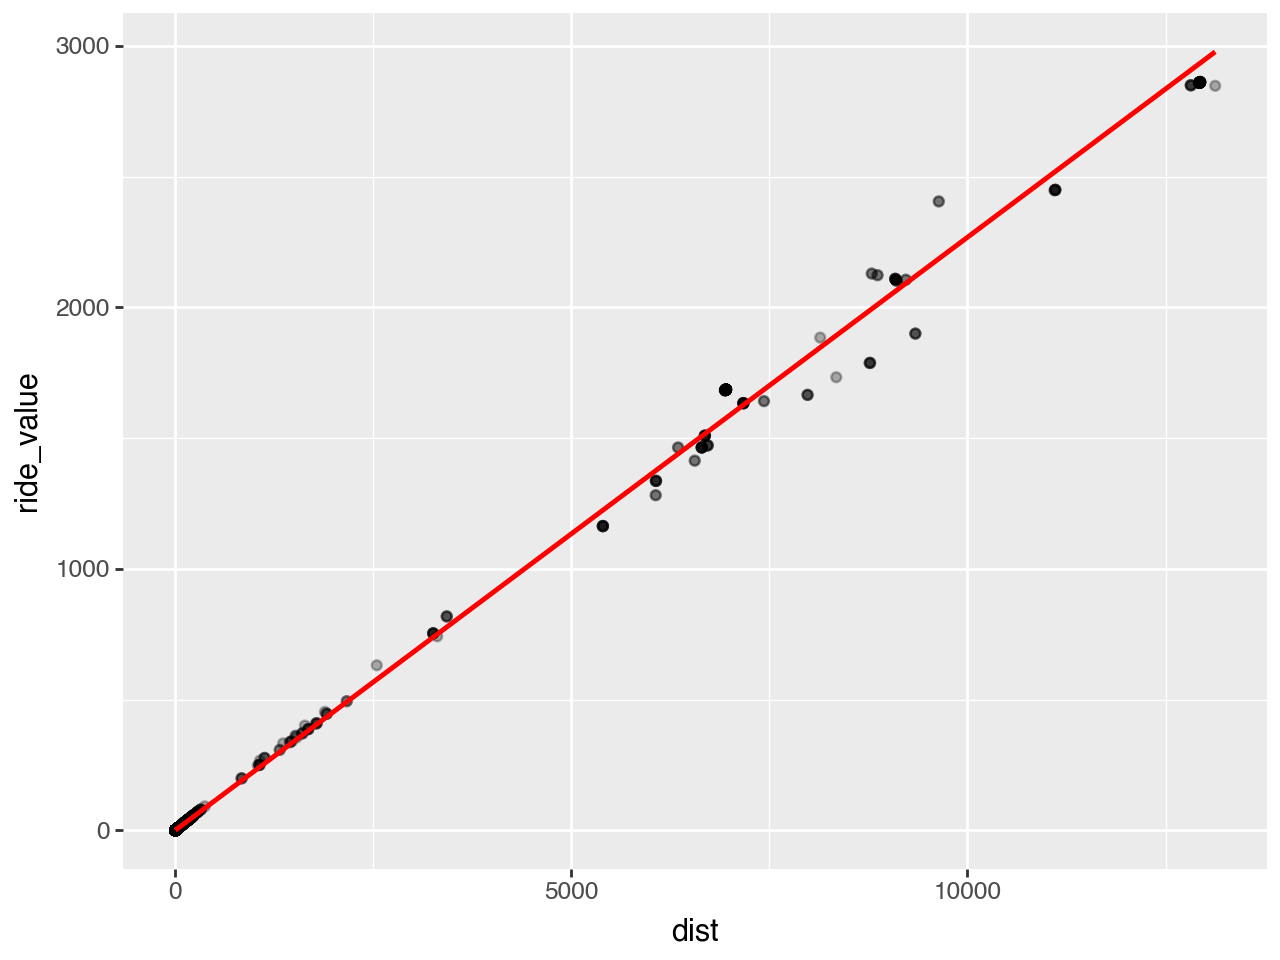

In [46]:
plot_data = df_train[["start_lat", "end_lat"]].melt()
# p9.ggplot(df,p9.aes(x="start_lat"))+p9.geom_histogram()

(
    p9.ggplot(df_train, p9.aes(x="dist", y="ride_value"))
    + p9.geom_point(alpha=0.3)
    + p9.geom_smooth(method="lm", colour="red")
)

    Eyeballing the plot of ride value vs distance, the ride values are consistent with the distance travelled (at all distanes).  Suggesting that outliers in ride_value identified are driven by outliers in end_coordinates.

/Users/seanviolante/miniforge3/envs/bolt/lib/python3.12/site-packages/mizani/bounds.py:243: RuntimeWarning: invalid value encountered in cast


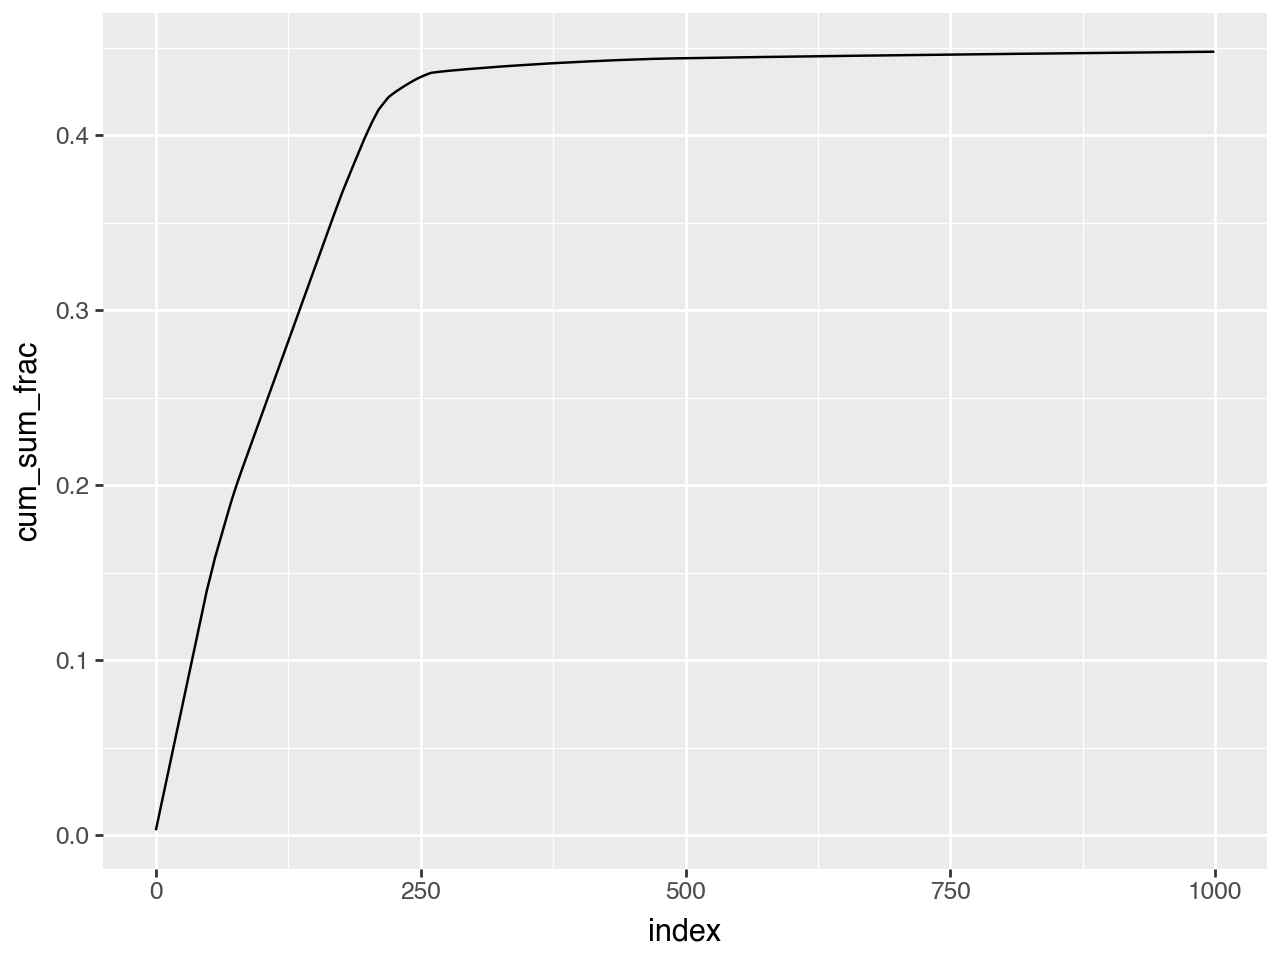

In [47]:
rides = (
    df_train.sort(by="ride_value", descending=True)
    .with_columns_seq(
        cum_sum=pl.col("ride_value").cum_sum(),
    )
    .with_columns_seq(
        cum_sum_frac=pl.col("cum_sum") / pl.col("cum_sum").last(),
    )
)
(
    p9.ggplot(
        rides.with_row_index("index").head(1000),
        p9.aes(x="index", y="cum_sum_frac"),
    )
    + p9.geom_line()
)

The first 250 highest value rides cover 44% of the total value.
Since we are looking at the *number* of rides, a small number of outlier distances/ride_values make no impact.
One would investigate further in reality.

## Spatial Patterns
Having bucketed the coordinates we can look at overall demand over the period with a heatmap.  To make sense of this, one would overlay it on a map of the city with points of interest etc.

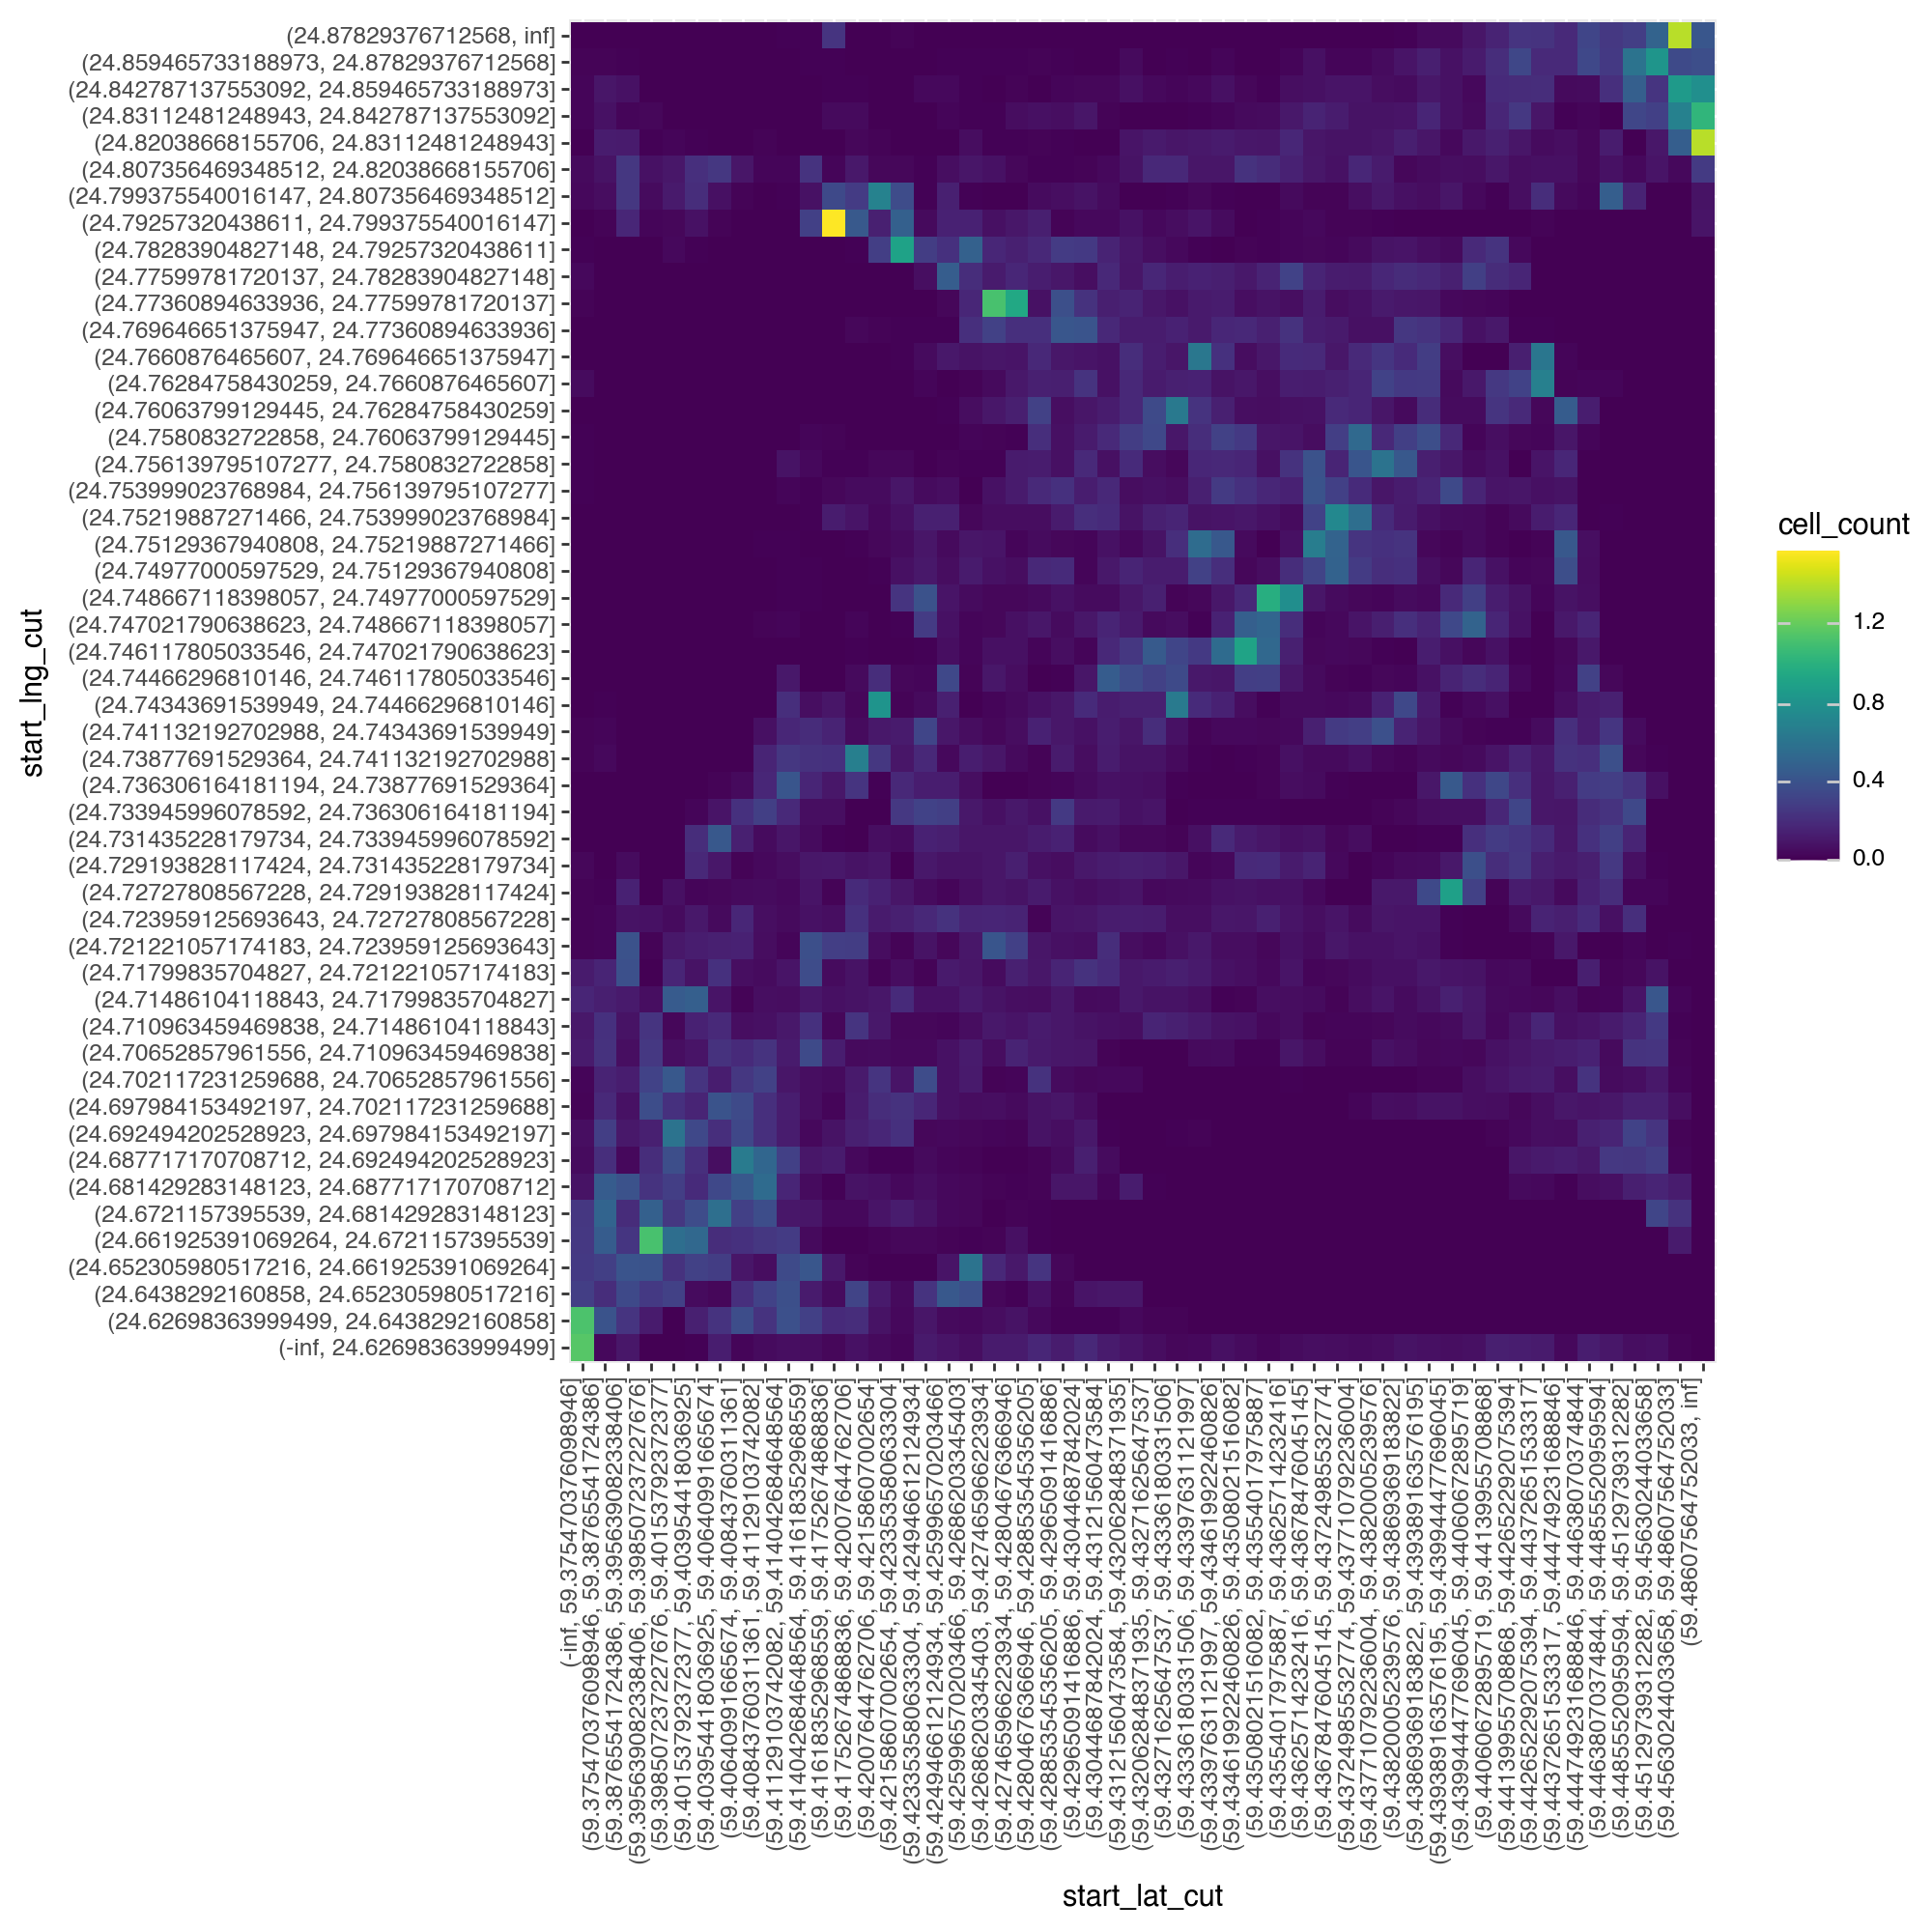

In [48]:
plot_data = df_cells_train.group_by(["start_lat_cut", "start_lng_cut"]).agg(
    pl.col("cell_count").mean()
)
(
    p9.ggplot(
        plot_data, p9.aes(x="start_lat_cut", y="start_lng_cut", fill="cell_count")
    )
    + p9.geom_tile()
    + p9.theme(figure_size=(10, 10), axis_text_x=p9.element_text(rotation=90, hjust=1))
)

### Movie

In [33]:
from plotnine.animation import PlotnineAnimation

plots = (
    p9.ggplot(
        df_cells_train.filter(pl.col("start_time_cut") == start_time_cut),
        p9.aes(x="start_lat_cut", y="start_lng_cut", fill="cell_count"),
    )
    + p9.geom_tile()
    + p9.lims(fill=(0, 16))
    + p9.theme(figure_size=(10, 10), axis_text_x=p9.element_text(rotation=90, hjust=1))
    + p9.labs(title=f"{start_time_cut}")
    for start_time_cut in df_cells_train.get_column("start_time_cut").unique().sort()
)
ani = PlotnineAnimation(plots, interval=100, repeat_delay=500)
ani

In [11]:
test_data = df_cells_train.sample(100).reset_index()
test_data = test_data.reset_index()

test_data["area"] = area_vec(test_data["start_lat_cut"], test_data["start_lng_cut"])

In [258]:
lat_cell = test_data.start_lat_cut.sample().iat[0]
lng_cell = test_data.start_lng_cut.sample().iat[0]

ar = area(lat_cell, lng_cell)
print(ar)
# area varies considerably because discretise by quantile

0.006287168669574675


np.float64(59.4064)

### Time Patterns
Once we have a Spatial cell structure, we can see how demand changes for a given cell over time.We choose the cell with the highest count.

In [10]:
i = df_cells_train.get_column("cell_count").arg_max()
df_cells_train[i]

start_lat_cut,start_lng_cut,start_time_cut,cell_count,dist_sum,dist_mean,ride_value_sum,ride_value_mean,start_lat_flr,start_lat_idx,start_lng_flr,start_lng_idx,start_time_day,start_time_cut_time,cell_count_lag_1,cell_count_lag_2,cell_count_lag_3
cat,cat,datetime[μs],u32,f64,f64,f64,f64,f64,i64,f64,i64,i8,i64,u32,u32,u32
"""(59.41618352968559, 59.4175267…","""(24.79257320438611, 24.7993755…",2022-03-19 22:00:00,16,74.817957,4.676122,18.493911,1.155869,59.416184,11,24.792573,42,6,1320,7,3,7


In [11]:
plot_data = df_cells_train.filter(
    (pl.col("start_lat_idx") == 11) & (pl.col("start_lng_idx") == 42)
)

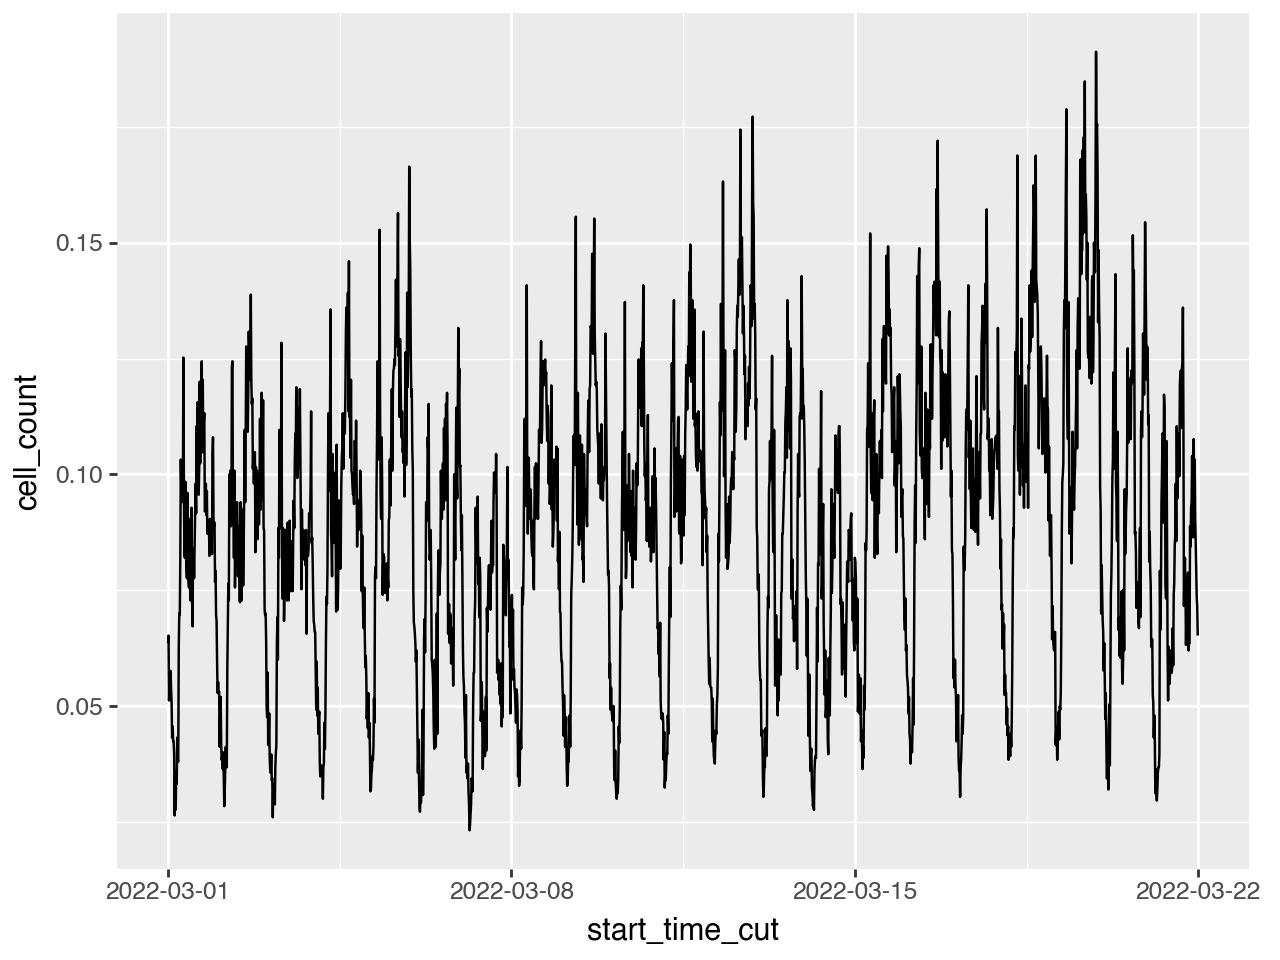

In [27]:
# plot_data.filter(pl.col('start_time_cut')<datetime.date(2022,3,8)),
plot_data = df_cells_train.group_by("start_time_cut").agg(pl.col("cell_count").mean())
(
    p9.ggplot(
        plot_data,
        p9.aes(x="start_time_cut", y="cell_count"),  # , colour="start_time_day"),
    )
    + p9.geom_line()
)

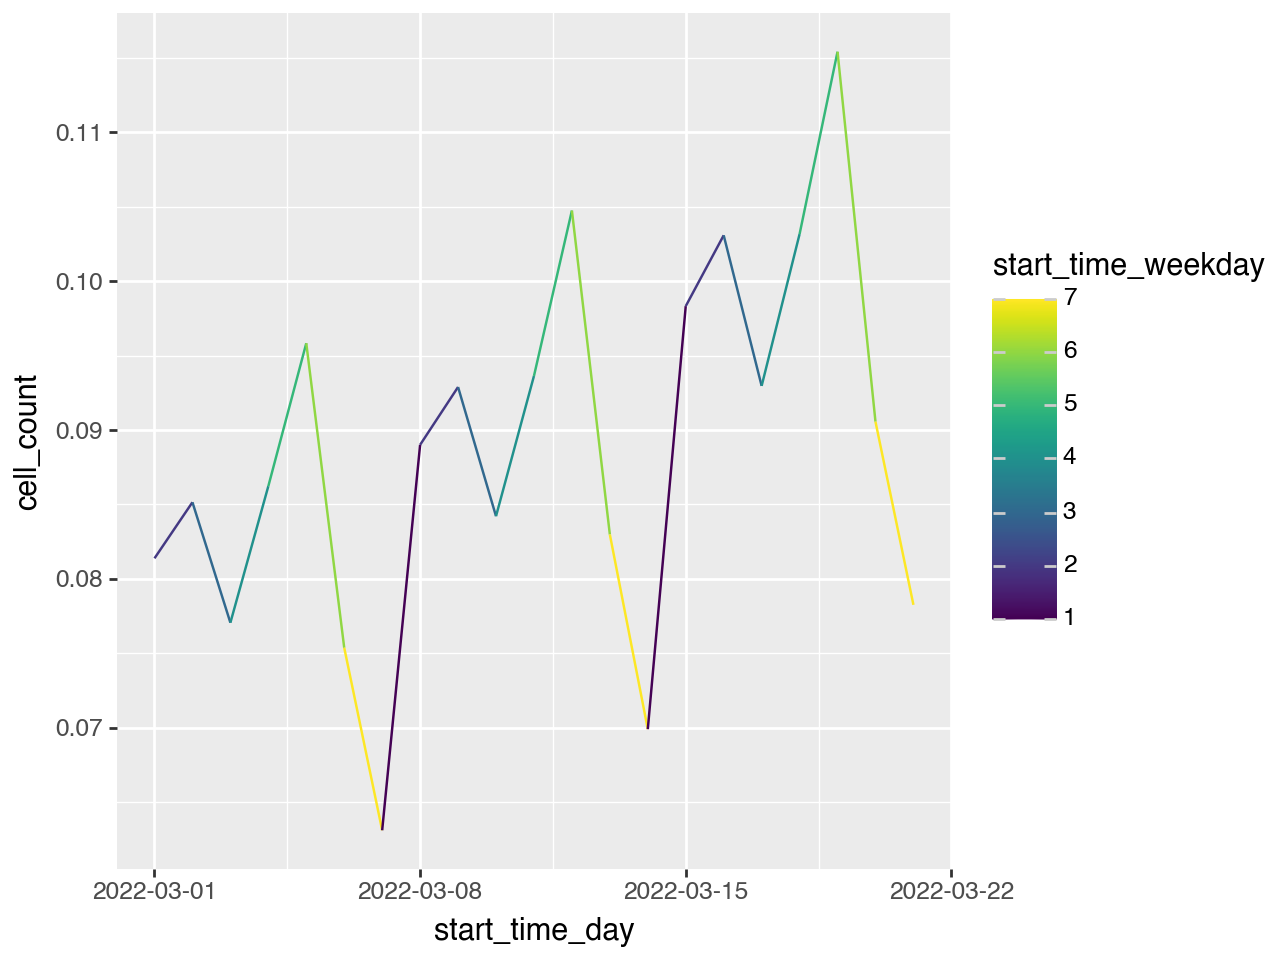

In [25]:
plot_data = df_cells_train.group_by(  # .filter((pl.col("start_lat_idx")==11) & (pl.col('start_lng_idx')==42))
    pl.col("start_time_cut").dt.date().alias("start_time_day")
).agg(
    pl.col("cell_count").mean()
)

(
    p9.ggplot(
        plot_data.with_columns(
            start_time_weekday=pl.col("start_time_day").dt.weekday()
        ),
        p9.aes(x="start_time_day", y="cell_count", color="start_time_weekday"),
    )
    + p9.geom_line()
)

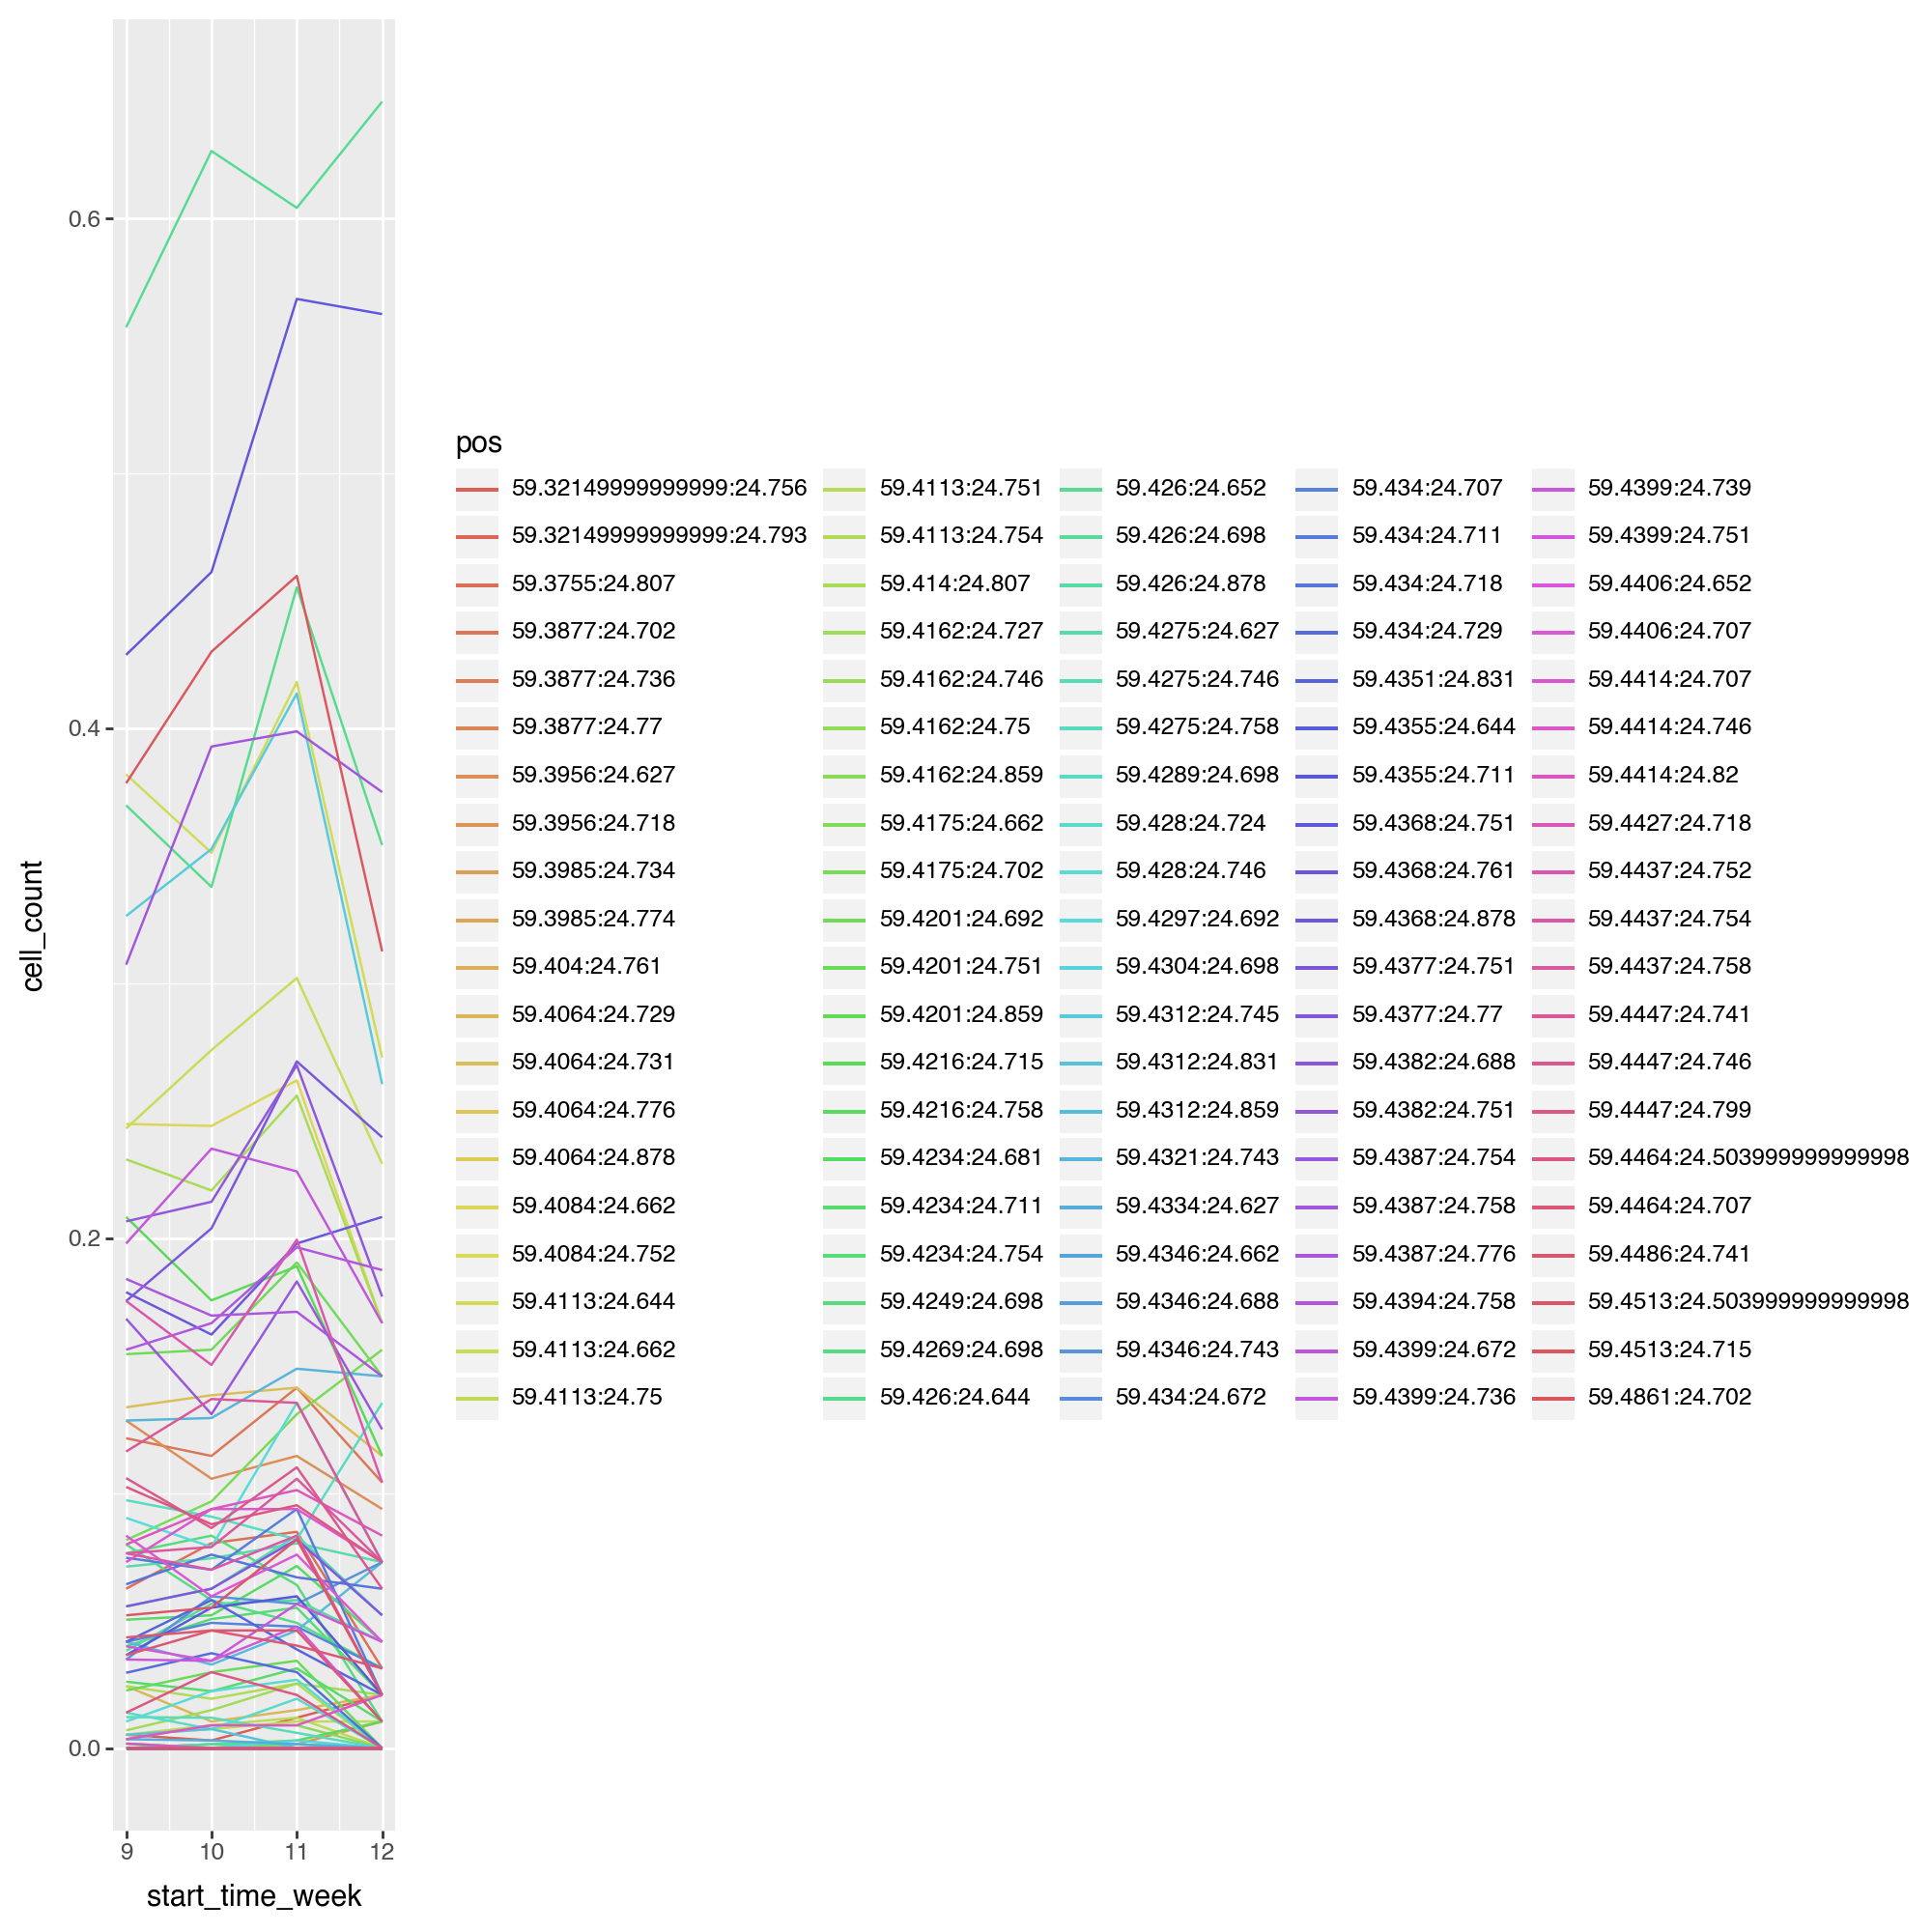

In [232]:
plot_data = (
    df_cells_train.reset_index()
    .assign(
        pos=lambda df: df.start_lat_flr.astype(str).str.cat(
            df.start_lng_flr.astype(str), sep=":"
        ),
        start_time_week=lambda df: df.start_time_cut.dt.isocalendar().week.astype(
            float
        ),
    )
    .groupby(
        ["pos", "start_lat_flr", "start_lng_flr", "start_time_week"], observed=True
    )["cell_count"]
    .mean()
    .reset_index()
)
pos_rand = plot_data.pos.sample(100).unique()

(
    p9.ggplot(
        plot_data.query("pos in @pos_rand"),
        p9.aes(x="start_time_week", y="cell_count", color="pos"),
    )
    + p9.geom_line()
    + p9.theme(figure_size=(10, 10))
)

In [223]:
plot_data.dtypes

start_time_week    float64
cell_count         float64
dtype: object

# Model Building
Having transformed the data into something which we can perform statistics on, we start building the model.
We use a Poisson based xgboost model to predict these ride counts.

The Poisson model is natural for count data.  Part of its advantages is the multiplicative effect of the inputs in the linear model. That is we expect eg a train station to have more demand, and this demand is damped/increased by a given percentage (rather than an additive amount) over rush hour etc.  Making use of a multiplicative model should enable the model to generalise better. eg don't have to learn time effect on every spatial cell, but have general time-effect multiplier. Taking logs of the counts is problematic, because many cells have zero value, also we then have to convert the Expectation of log counts into the expectation of the counts, which is not straightforward.


In [6]:
# we look at the performance of a baseline model always predicting the same count, to sensecheck our results.
# These values are similar to the initial tree error values
e_cnt_train = df_cells_train.get_column("cell_count").mean()
null_trn = null_deviance(df_cells_train.get_column("cell_count"))
null_tst = null_deviance(df_cells_test.get_column("cell_count"), e_cnt_train)
print(f"e_cnt_train:{e_cnt_train}, null_trn: {null_trn} null_tst {null_tst}")

AttributeError: 'Series' object has no attribute 'when'

In [32]:
# create input data for xgboost

inputs = [
    "start_lat_flr",
    "start_lng_flr",
    "start_time_cut",
    "start_time_day",
    # "start_time_cut_time",
    # "cell_count_lag_1","cell_count_lag_2","cell_count_lag_3"
]
train_data = (
    df_cells_train.select(inputs)
    .with_columns(
        pl.col("start_lat_flr").replace([-np.inf, np.inf], [-90, 90]),
        pl.col("start_lng_flr").replace([-np.inf, np.inf], [-180, 180]),
    )
    .cast(pl.Float64)
)
test_data = (
    df_cells_test.select(inputs)
    .with_columns(
        pl.col("start_lat_flr").replace([-np.inf, np.inf], [-90, 90]),
        pl.col("start_lng_flr").replace([-np.inf, np.inf], [-180, 180]),
    )
    .cast(pl.Float64)
)

train_label = df_cells_train.get_column("cell_count").to_numpy()
test_label = df_cells_test.get_column("cell_count").to_numpy()
dmat_train = xgb.DMatrix(
    data=train_data.to_numpy(), label=train_label, feature_names=inputs
)
dmat_test = xgb.DMatrix(
    data=test_data.to_numpy(),
    label=test_label,
    feature_names=inputs,
)

In [37]:
aa = bst.trees_to_dataframe()
aa.describe()

,Tree,Node,Split,Gain,Cover,Category
count,10000.000000,10000.000000,4.918000e+03,10000.000000,1.000000e+04,0.0
mean,7.705200,397.573400,2.501703e+14,48.132121,4.103981e+04,NaN
std,11.795991,269.046232,5.912072e+14,244.980348,1.963110e+05,NaN
min,0.000000,0.000000,2.000000e+00,-0.496446,3.700305e+00,NaN
25%,4.000000,168.000000,2.474466e+01,-0.158584,6.982437e+02,NaN
50%,7.000000,371.000000,5.941129e+01,0.700000,2.108044e+03,NaN
75%,9.000000,590.000000,5.944140e+01,33.875710,7.879981e+03,NaN
max,163.000000,1164.000000,1.647899e+15,10478.040000,6.455174e+06,NaN


In [39]:
import wandb
from wandb.integration.xgboost import WandbCallback

run = wandb.init(project="rides", job_type="train-val-split")
bst_params = {"objective": "count:poisson", "eta": 0.3, "max_depth": 6, "gamma": 0}
# gamma min split loss
run.config.update(bst_params)
run.config.update(
    {
        "num_boost_round": 1000,
        "early_stopping_rounds": 5,
    }
)

evals_result = {}
bst = xgb.train(
    params=bst_params,
    dtrain=dmat_train,
    num_boost_round=run.config["num_boost_round"],
    early_stopping_rounds=run.config["early_stopping_rounds"],
    evals=[(dmat_train, "train"), (dmat_test, "test")],
    evals_result=evals_result,
    callbacks=[WandbCallback(log_model=True)],
    verbose_eval=True,
)
trees_df = bst.trees_to_dataframe()
#  Tree Node Id Feature(name) Split(metric) Yes(id) No(id) Missing(id) Gain(metric) Cover(metric)

table = wandb.Table(dataframe=trees_df.describe())
run.log({"tree_stats": table})
run.finish()

[0]	train-poisson-nloglik:0.62534	test-poisson-nloglik:0.64778
[1]	train-poisson-nloglik:0.57044	test-poisson-nloglik:0.59915
[2]	train-poisson-nloglik:0.52440	test-poisson-nloglik:0.55850
[3]	train-poisson-nloglik:0.48591	test-poisson-nloglik:0.52463
[4]	train-poisson-nloglik:0.45387	test-poisson-nloglik:0.49620
[5]	train-poisson-nloglik:0.42727	test-poisson-nloglik:0.47213
[6]	train-poisson-nloglik:0.40535	test-poisson-nloglik:0.45313
[7]	train-poisson-nloglik:0.38731	test-poisson-nloglik:0.43666
[8]	train-poisson-nloglik:0.37259	test-poisson-nloglik:0.42390
[9]	train-poisson-nloglik:0.36063	test-poisson-nloglik:0.41326
[10]	train-poisson-nloglik:0.35092	test-poisson-nloglik:0.40389
[11]	train-poisson-nloglik:0.34315	test-poisson-nloglik:0.39706
[12]	train-poisson-nloglik:0.33695	test-poisson-nloglik:0.39130
[13]	train-poisson-nloglik:0.33197	test-poisson-nloglik:0.38670
[14]	train-poisson-nloglik:0.32802	test-poisson-nloglik:0.38217
[15]	train-poisson-nloglik:0.32491	test-poisson-nl

best_iteration,▁
best_score,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test-poisson-nloglik,█▆▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train-poisson-nloglik,█▆▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
best_iteration,86
best_score,0.32114
epoch,91
test-poisson-nloglik,0.32119
train-poisson-nloglik,0.26697


In [79]:
plot_data

metric,feature,value
str,str,f64
"""weight""","""start_lat_flr""",141880.0
"""weight""","""start_lng_flr""",137316.0
"""weight""","""start_time_day""",100358.0
"""weight""","""start_time_cut_time""",152873.0
"""gain""","""start_lat_flr""",3.353714
…,…,…
"""total_gain""","""start_time_cut_time""",231688.90625
"""total_cover""","""start_lat_flr""",8.61715136e8
"""total_cover""","""start_lng_flr""",8.76671168e8


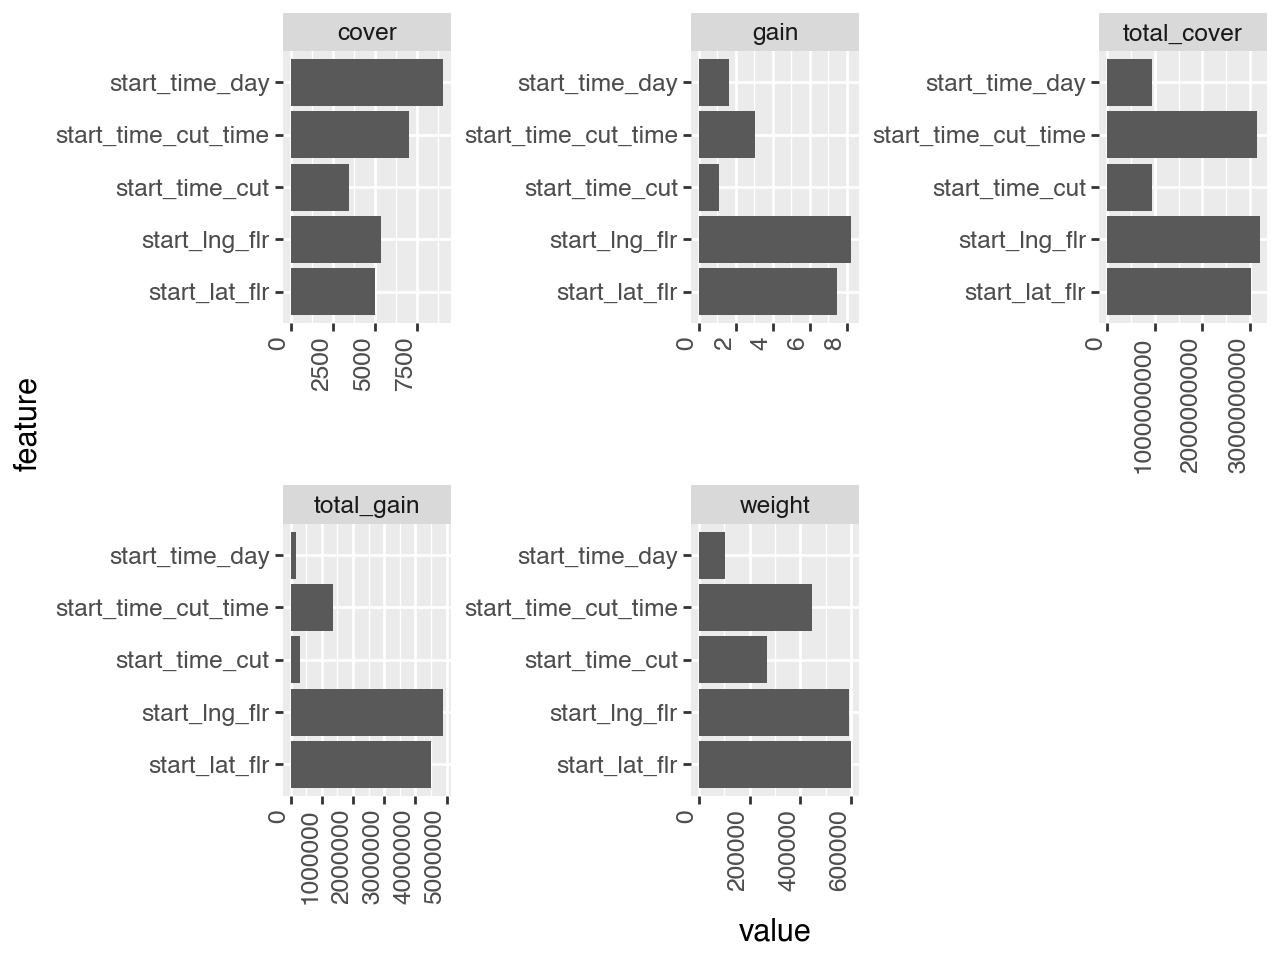

In [94]:
bst.feature_names = inputs
metrics = [
    "gain",
    "total_gain",
    "cover",
    "total_cover",
    "weight",
]
score_dfs = []
for metric in metrics:
    score = bst.get_score(importance_type=metric)
    score_df = pl.DataFrame(
        {"metric": metric, "feature": score.keys(), "value": score.values()}
    )
    score_dfs.append(score_df)
scores_all = pl.concat(score_dfs)  # .pivot(on="metric",index="feature", )

plot_data = scores_all
(
    p9.ggplot(plot_data, p9.aes(x="feature", y="value"))
    + p9.geom_bar(stat="identity")
    + p9.theme(axis_text_x=p9.element_text(rotation=90, hjust=1))
    + p9.coord_flip()
    + p9.facet_wrap("metric", scales="free")
)

In [30]:
zz.groupby("Feature").agg(
    {"Node": ["count"], "Gain": ["mean", "sum"], "Cover": ["mean", "sum"]}
)

Node       Gain                        Cover  \
                      count       mean            sum          mean   
Feature                                                               
Leaf                 163098  -0.025153   -4102.345086    729.211891   
start_lat_flr         51256  13.830366  708889.254181   7132.699437   
start_lng_flr         52082  15.006326  781559.485814   7497.837164   
start_time_cut        16359   2.038053   33340.501049   6040.514124   
start_time_cut_time   35874   5.616975  201503.367739   9367.929584   
start_time_day         7439   3.054192   22720.137207  14045.156415   

                                   
                              sum  
Feature                            
Leaf                 1.189330e+08  
start_lat_flr        3.655936e+08  
start_lng_flr        3.905024e+08  
start_time_cut       9.881677e+07  
start_time_cut_time  3.360651e+08  
start_time_day       1.044819e+08

ImportError: You must install graphviz to plot tree

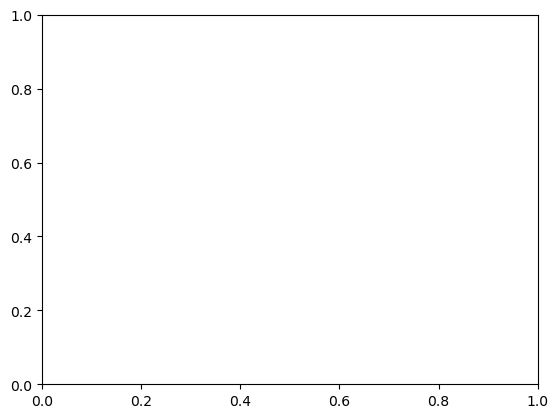

In [25]:
xgb.plot_tree(bst, num_trees=0)

In [76]:
scores_all

feature,weight,gain,cover,total_gain,total_cover
str,f64,f64,f64,f64,f64
"""start_lat_flr""",141880.0,3.353714,6073.548828,475825.0,8.61715136e8
"""start_lng_flr""",137316.0,3.709875,6384.333496,509425.1875,8.76671168e8
"""start_time_day""",100358.0,0.684723,2231.811279,68717.390625,2.23980128e8
"""start_time_cut_time""",152873.0,1.515565,6128.119141,231688.90625,9.36823936e8


In [31]:
141880 * 3.35373

475827.2124

In [156]:
bst

{'best_iteration': '999', 'best_score': '0.25462971803337026'}

In [26]:
evals_result["test"]["poisson-nloglik"]

[0.5186107860421496,
 0.4133695672082227,
 0.3656394787609666,
 0.34208756189567613,
 0.3279664147126954,
 0.3144675280482442,
 0.31123656489578677,
 0.3056046636370471,
 0.2946718791453678,
 0.29450904887796553,
 0.2945225097925496,
 0.2945326313394887,
 0.2945437606135081,
 0.2894302697506708,
 0.2894238443518792,
 0.28943190360871046,
 0.28944165712964104,
 0.2894466962639093,
 0.28944926575400226,
 0.289450567572218]

In [60]:
bst.feature_names = inputs

## Model variations
The potential model inputs chosen were the latitude and longitude of the cell, the week day, the time of the day, together with lagged values of the cell count in the previous 3 15 minute intervals

We considered 2 basic models, using all the above inputs and dropping the lagged variables.

We investigated the effect of *eta* (0.3, 0.6) and tree depth (6,12), we used stop training with maximum of 1000 and early_stopping of 5 rounds.

## Model evaluation
We considered roughly the last week of data as a validation set, using the previous 3 weeks as training data.  This implicitly assumes that retraining is done weekly, which implies that any mispredictions are not corrected for a week.  A more accurate approach would be to do a 'timeseries validation', where eg we retrain a model for every 15 minutes of the test period (eg week).  This more accurately represents the use case where we want to find the best model at predicting only the next 15 minutes (because the drivers are using it only to plan where they move next).

This is a preliminary approach.  Ideally one would develop a metric that was independent of the model and discretisation choice (so that we could eg compare the relative benefits of quantile and linear binning in a consistent fashion).

## Results
 
|Inputs | eta| tree_depth|best_iteration| train_loss| test_loss|
|-------|-----|----------|--------------| -|-|
|all    |0.3  |         6|   999        |  0.2302    | 0.2669 |
|all| 0.6|              6|           774|  0.2250 |0.2627|
|all    | 0.6 | 12       |           125|0.20022| 0.26151|
|no lags| 0.3 |         6| 999| 0.22378| 0.25872|
|no lags| 0.6 |         6| 999| 0.21856|0.25463|
|no lags| 0.3 |        12| 219| 0.20384|0.26164|
|no lags| 0.6 |        12| 245|0.18307| *0.24365*|


## Model Conclusion
The current results do not seem to show a benefit from lagged data, rather the opposite.  This is puzzling, one might expect that adding lags would certainly do no worse.  In addition, the intention of adding the lags was to make the model 'responsive' - even if the model was updated once a week, any mismatches between the expected demand based on weekly/hourly cycles could potentially be compensated by using eg the previous 15 minutes values. One possible explanation is that our chosen discretisation is too fine, and the lagged values would need to be aggregated in space.



# Model Purpose and Communication to drivers
The purpose of the model is to guide the drivers towards areas with higher expected demand at a given time and location.  However, the drivers also need to take into account what the expected supply of drivers is, together with driving costs etc.  Therefore a model predicting demand should feed into a larger system that takes into account the number of drivers already at that location, or approaching that location (ie an expected supply). The drivers would then be informed of the expected *excess* demand.

How the drivers use the model would require some discussion with representative drivers,and knowledge of their working practise.  One application (A) is simply to assess where they work the next day: the driver looks at the pattern for the next day ( eg a 'movie' of demand heat map) and decides where they will start their day, where they move to over time.  It seems very doubtful that any performance improvement could be measured from this approach (driver/company profit), because the range of actions open to drivers is unlimited.

The more automated way (B) is that the driver literally just follows what the system tells him/her at any moment.  This requires more trust that the system has taken into account all the variables that will optimise their profit (as mentioned there are costs to moving etc.)  In addition, the model should be updated in 'real time'.  In the above case study, we predict the weekly patterns etc, and our validation set is ~ 1 week, which implies a weekly training schedule.  The lagged data would give "up to the (15) minute" information, correcting any mismatches from typical patterns, but in the synthetic data it didn't seem to be very helpful (would need further investigation).

## Additional inputs
To predict demand additional inputs would be POIs, and event calendars ( eg conferences/trade fairs/holidays).  As mentioned, to solve the business problem a separate model of predicted supply is also needed.

## Design of experiment
To test the *expected demand* does not require an experiment.  It can be tested offline - one can review and identify the best model, based on whatever metric one chooses.  This would arguably be sufficient for (A), and would be a good stepping stone for acceptance of the model.

An experiment is needed when we are evaluating the driver's actions.  Assuming that the driver has 'access' to a model of expected *excess* demand, then its not so clear how the driver should use it. How far does the driver drive for what level of excess demand?  How to juggle demand vs ride value. I imagine that company would have an overall calculation of driving cost, ride value etc, which would allow simulation of possible strategies.  Having shown through simulation that a given strategy produced more profit for company and driver, one would then propose that strategy to drivers. eg 'Whenever you are idle,  drive to the highest excess demand within 5 km of your current location'.

It would be more practical to A/B test by driver - otherwise there are likely to be interference effects where eg the driver follows a recommendation on days when he is in the control based on patterns learned on previous days.

One might consider 'vetting' rides for a cleaner statistical result. Eg exclude rides that were fixed before the driver reached the target zone. One would need to take into account the filtered rides in any calculation eg if only 10% of rides satisfy the test criteria, then will have a correspondingly smaller impact on daily profit. 


# design and deployment
The basic approach follows standard model deployment setups.
A training server that pulls the data on a fixed interval, trains the model and saves it in the cloud (eg AWS S3).
Prediction servers that run continuously load the model and provide a prediction service based on an API.  Prediction servers could eg be deployed using AWS sagemaker.



